In [53]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic_2d, binned_statistic

#
from dlnpyutils import robust

In [2]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

# PARSEC

In [3]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','Mass','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# APOKASC

In [4]:
from astropy.io import ascii

kasc672 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.2.fits.gz')
kasc3 = ascii.read('MLtesterr3bDR16A3PalphaM_july5.out')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')

# xmatch APOKASC Catalogs
_, k672idx, k3idx = np.intersect1d(kasc672['2MASS_ID'],kasc3['2MASSID'],return_indices=True)
k672 = kasc672[k672idx]
k3 = kasc3[k3idx]

<ipython-input-5-864b270c4e6a>:17: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


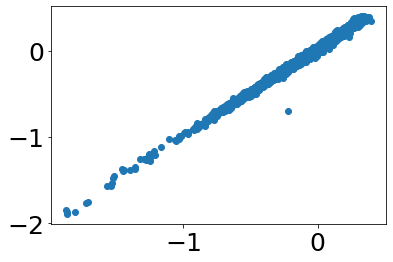

In [5]:
# xmatch APOKASC with DR17
_, k3idx, dr17idx = np.intersect1d(k3['2MASSID'],dr17['APOGEE_ID'],return_indices=True)

k672dr17 = k672[k3idx]
k3dr17 = k3[k3idx]
kdr17 = dr17[dr17idx]


# Select RGB stars
ageevs = np.where((k3dr17['IntAge']>-10.)&(k672dr17['APOKASC3_CONS_EVSTATES']==1.0)&
                  (kdr17['GAIAEDR3_PARALLAX']/kdr17['GAIAEDR3_PARALLAX_ERROR']>3.0))

k672dr17 = k672dr17[ageevs]
k3dr17 = k3dr17[ageevs]
kdr17 = kdr17[ageevs]

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

plt.scatter(kdr17['FE_H'],k3dr17['Fe/H'])

# Gaia Magnitude Errors

In [6]:
from scipy.stats import binned_statistic
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

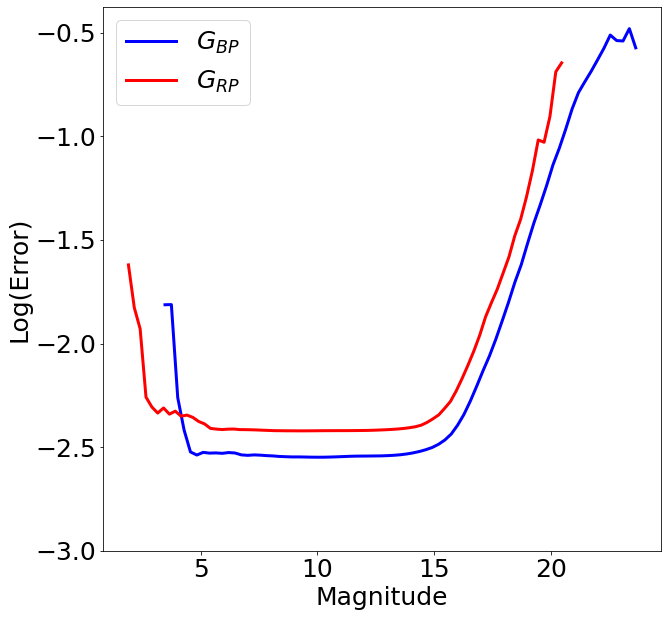

In [7]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

# dTeff Functions

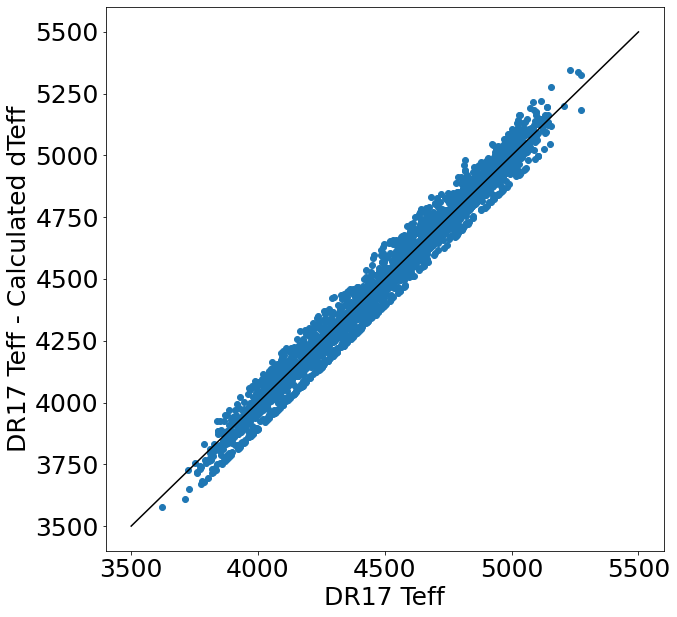

In [8]:
### See IsochroneShiftsCleanedUp

def dteff_feh_k(x,a,b,feh0,dteff0):
    return np.piecewise(x,[x<feh0],[lambda x: dteff0, 
                                    lambda x: a*(x**2-feh0**2)+b*(x-feh0)+dteff0])
# Fit Parameters:
# a = -134.56129
# b = -16.84827
# feh0 = -0.62602
# dteff0 = -4.71220

def dteffresid_age_k(x,a,b,c,dteff0_age):
    return np.piecewise(x,[x>13.787],[lambda x: dteff0_age, 
                                    lambda x: a*(x**3-13.787**3)+b*(x**2-13.787**2)+c*(x-13.787)+dteff0_age])

# Fit Parameters:
# a = 0.62717
# b = -14.69484
# c = 104.66032
# dteff0_age = 69.53277

newTeff = kdr17['TEFF'] - (dteffresid_age_k(k3dr17['IntAge'],0.62717,-14.69484,104.66032,69.53277)+
                           dteff_feh_k(kdr17['FE_H'],-134.56129,-16.84827,-0.62602,-4.71220))

plt.figure(figsize=[10,10])
plt.scatter(kdr17['TEFF'],newTeff)
plt.plot([3500,5500],[3500,5500],c='k')
plt.xlabel(r'DR17 Teff')
plt.ylabel(r'DR17 Teff - Calculated dTeff')
plt.show()

# Compare dTeff Results to No dTeff Results

In [256]:
# agetab = Table(fits.getdata('aetas_apokascfullfehAA_results.fits'))
# agetab = Table(fits.getdata('aetas_apokasc_kascfeh_results.fits'))
agetab = Table(fits.getdata('aetas_apokasc_dr17_results.fits'))
agetab_logg = Table(fits.getdata('aetas_apokasc_dteff_logg_dr17.fits')) #_calcage
agetab_k = Table(fits.getdata('aetas_apokasc_dteff_k_dr17.fits'))

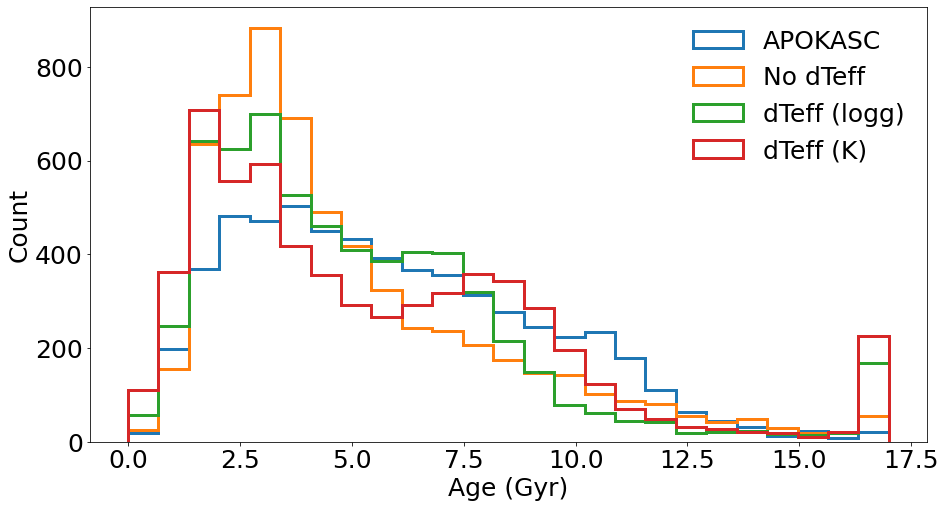

In [257]:
plt.figure(figsize=[15,8])
plt.hist(k3dr17['IntAge'],range=(0,17),bins=25,density=False,histtype='step',lw=3.0,label='APOKASC')
plt.hist(agetab['AGE'],range=(0,17),bins=25,density=False,histtype='step',lw=3.0,label='No dTeff')
plt.hist(agetab_logg['AGE'],range=(0,17),bins=25,density=False,histtype='step',lw=3.0,label='dTeff (logg)')
plt.hist(agetab_k['AGE'],range=(0,17),bins=25,density=False,histtype='step',lw=3.0,label='dTeff (K)')
plt.legend(frameon=False)
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'Count')
# plt.savefig('../plots/kasc_agefullfeh_histogramA.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [258]:
def upturn10Gyr(age):
    '''
    Boundary for 10 Gyr upturn in Aetas and APOKASC plot 
    
    Input:
    -----
        age: age in Gyr
        
    Output:
    ------
        ups: value on boundary 
    '''
    ups = np.ones(np.size(age))
    for i in range(np.size(age)):
        if age[i] <= 11:
            up = 11

        else:
            up = age[i]
            
        ups[i] = up

    return ups

def oldapokasc(age):
    '''
    Boundary for old stars in APOKASC given young age by Aetas
    
    Input:
    -----
        age: age in Gyr
    
    Output:
    ------
        olds: value on boundary
    '''
    olds = np.ones(np.size(age))
    for i in range(np.size(age)):
        olds[i] = age[i] - 4
        
    return olds

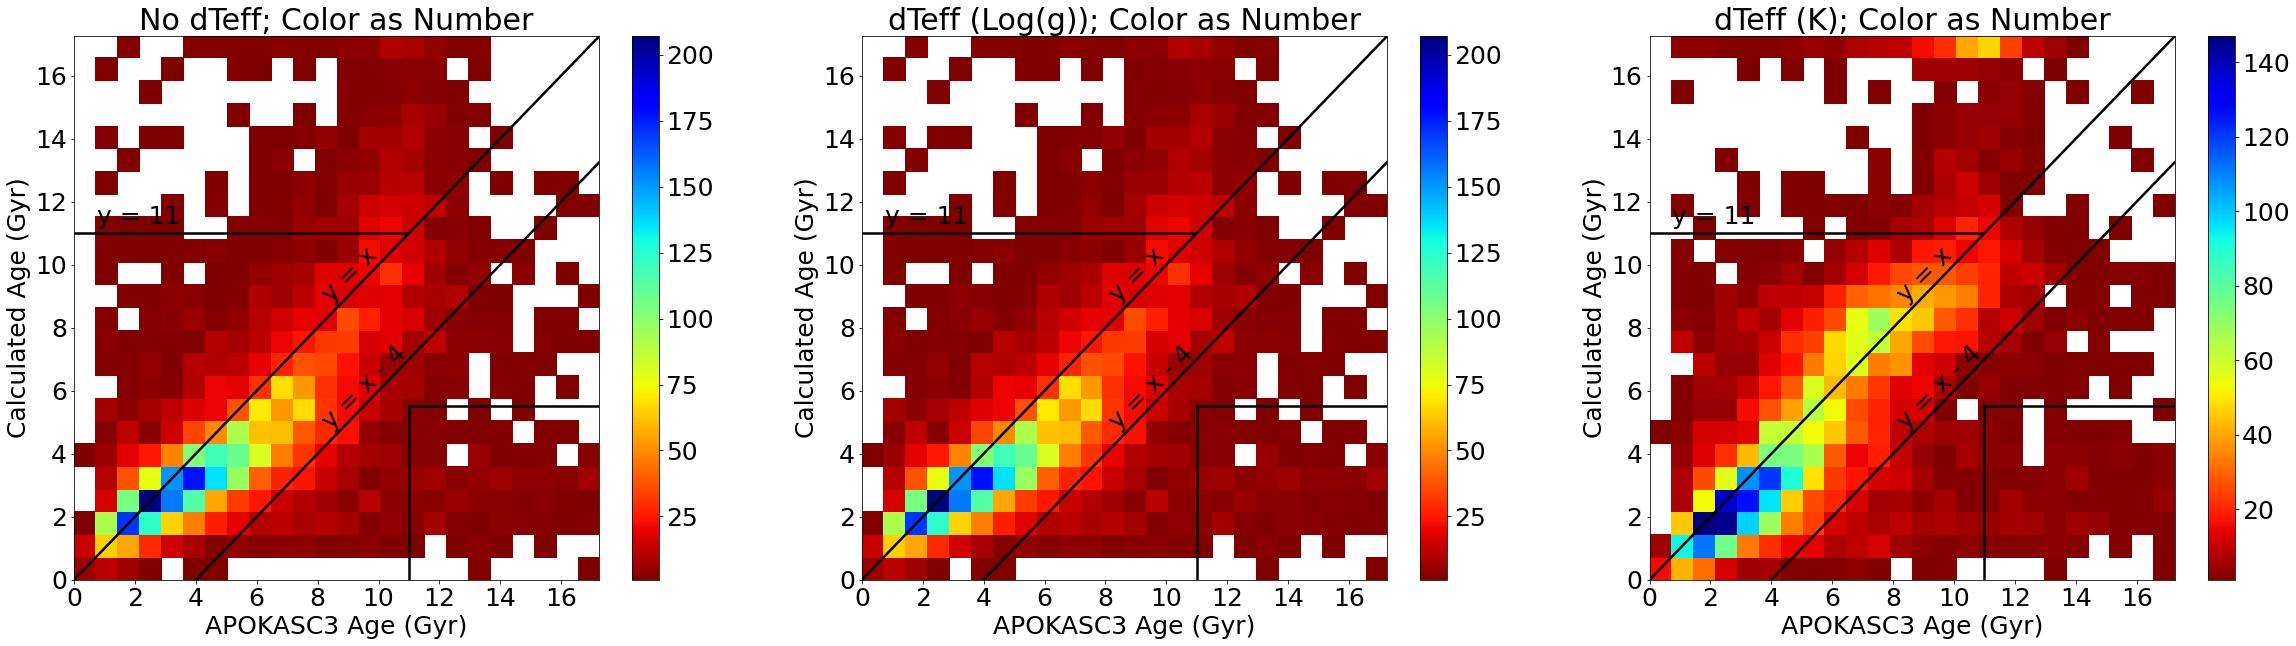

In [259]:
###
badcut = np.where(agetab['AGE']<999999.0)

x = k3dr17['IntAge'][badcut]
y = agetab['AGE'][badcut]

###
badcut_logg = np.where(agetab_logg['AGE']<999999.0)

x_logg = k3dr17['IntAge'][badcut_logg]
y_logg = agetab['AGE'][badcut_logg]

###
badcut_k = np.where(agetab_k['AGE']<999999.0)

x_k = k3dr17['IntAge'][badcut_k]
y_k = agetab_k['AGE'][badcut_k]

xmax = 18
ymax = 18
nbins = 25

plt.figure(figsize=[40,10])

plt.subplot(131)
plt.hist2d(x,y,bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)],cmap='jet_r',cmin=1)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
cbar = plt.colorbar()
plt.title(r'No dTeff; Color as Number')

plt.subplot(132)
plt.hist2d(x_logg,y_logg,bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)],cmap='jet_r',cmin=1)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
cbar = plt.colorbar()
plt.title(r'dTeff (Log(g)); Color as Number')

plt.subplot(133)
plt.hist2d(x_k,y_k,bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)],cmap='jet_r',cmin=1)
plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.xlabel('APOKASC3 Age (Gyr)')
plt.ylabel('Calculated Age (Gyr)')
cbar = plt.colorbar()
plt.title(r'dTeff (K); Color as Number')

# plt.savefig('../plots/age_age_count_fullfehkascA.pdf',dpi=300,bbox_inches='tight')
plt.show()

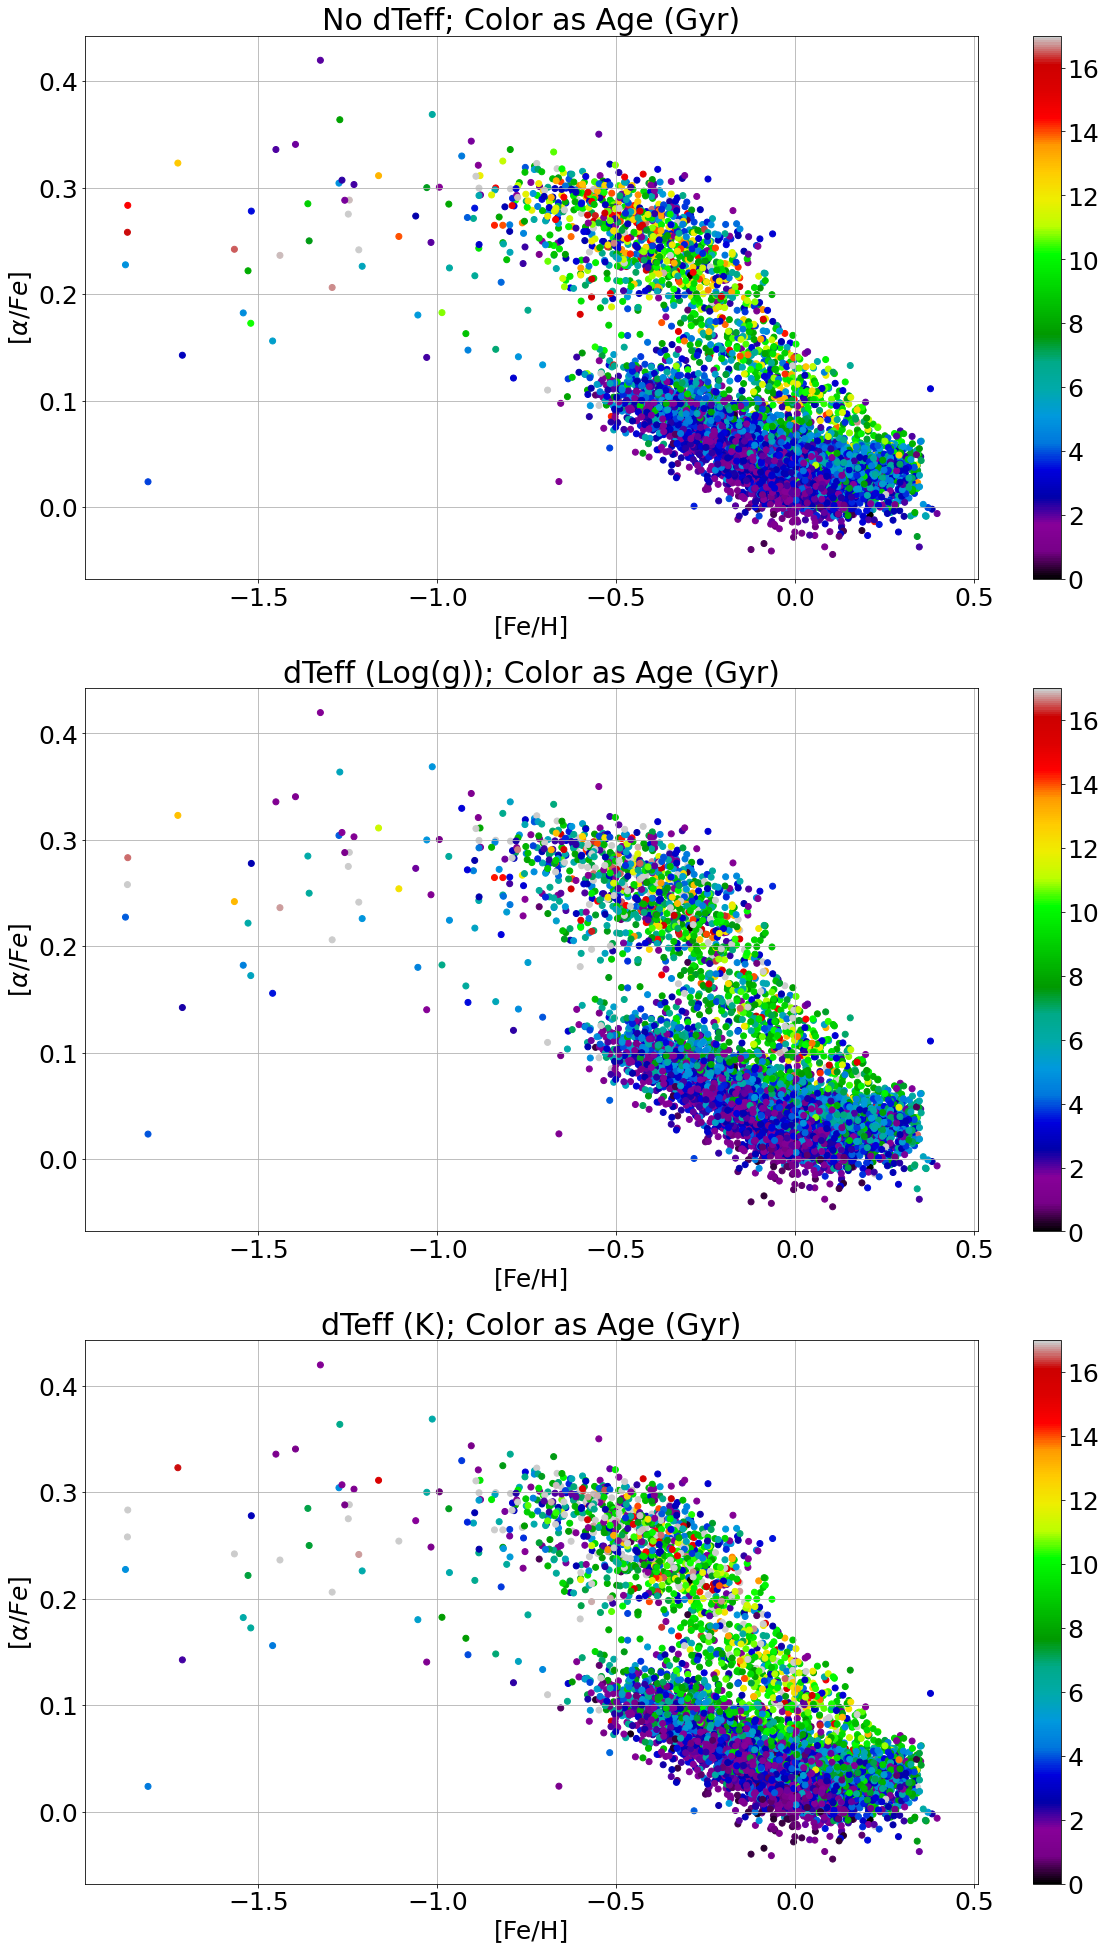

In [260]:
plt.figure(figsize=[20,34])

plt.subplot(311)
plt.scatter(kdr17[badcut]['FE_H'],apoafe[badcut],c=agetab['AGE'][badcut],cmap='nipy_spectral')
plt.colorbar()

plt.title(r'No dTeff; Color as Age (Gyr)')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha/Fe$]')
plt.grid()

plt.subplot(312)
plt.scatter(kdr17[badcut_logg]['FE_H'],apoafe[badcut_logg],c=agetab_logg['AGE'][badcut_logg],cmap='nipy_spectral')
plt.colorbar()

plt.title(r'dTeff (Log(g)); Color as Age (Gyr)')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha/Fe$]')
plt.grid()

plt.subplot(313)
plt.scatter(kdr17[badcut_k]['FE_H'],apoafe[badcut_k],c=agetab_k['AGE'][badcut_k],cmap='nipy_spectral')
plt.colorbar()

plt.title(r'dTeff (K); Color as Age (Gyr)')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha/Fe$]')
plt.grid()

# plt.savefig('../plots/kasc_afe_feh_agefullfehA.pdf',dpi=300,bbox_inches='tight')
plt.show()

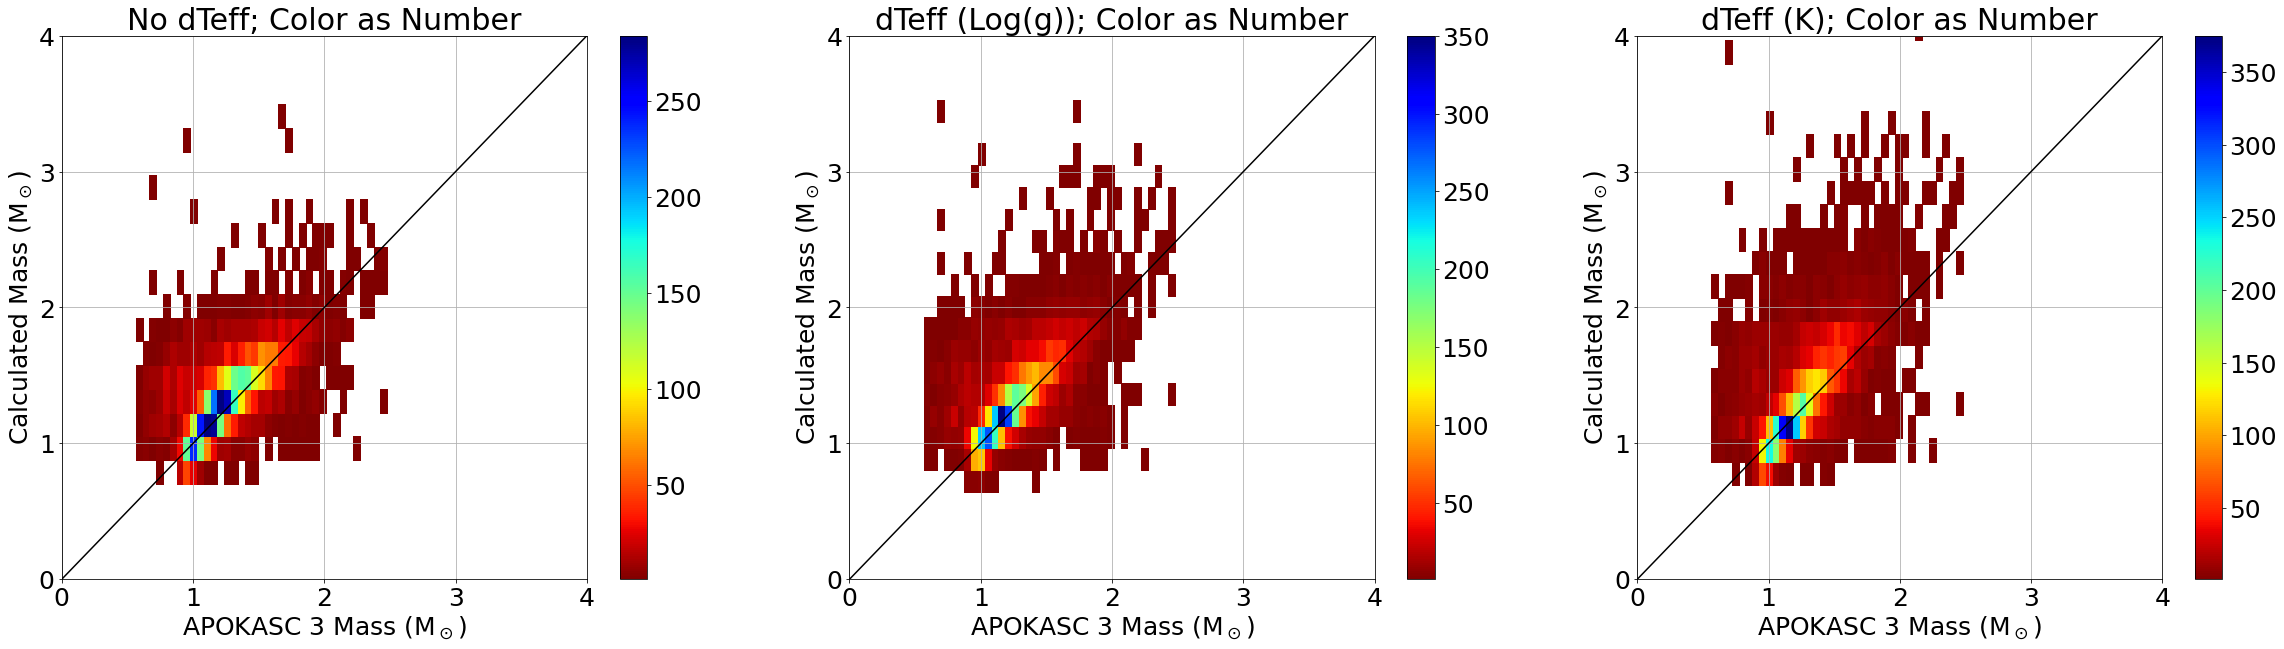

In [261]:
plt.figure(figsize=[40,10])

###
xmass = k3dr17['Mass'][badcut]
ymass = agetab['MASS'][badcut]

plt.subplot(131)
plt.hist2d(xmass,ymass,bins=[np.arange(0,max(xmass),max(xmass)/50),np.arange(0,max(ymass),max(ymass)/75)],
           cmap='jet_r',cmin=1)

plt.plot([0,8],[0,8],c='k')

plt.xlim(0,4)
plt.ylim(0,4)

plt.yticks(np.arange(0,5),np.arange(0,5).astype('str'))
plt.grid()

plt.title(r'No dTeff; Color as Number')
plt.xlabel('APOKASC 3 Mass (M$_\odot$)')
plt.ylabel('Calculated Mass (M$_\odot$)')
plt.colorbar()

###
xmass_logg = k3dr17['Mass'][badcut_logg]
ymass_logg = agetab_logg['MASS'][badcut_logg]
plt.subplot(132)
plt.hist2d(xmass_logg,ymass_logg,
           bins=[np.arange(0,max(xmass_logg),max(xmass_logg)/50),np.arange(0,max(ymass_logg),max(ymass_logg)/75)],
           cmap='jet_r',cmin=1)

plt.plot([0,8],[0,8],c='k')

plt.xlim(0,4)
plt.ylim(0,4)

plt.yticks(np.arange(0,5),np.arange(0,5).astype('str'))
plt.grid()

plt.title(r'dTeff (Log(g)); Color as Number')
plt.xlabel('APOKASC 3 Mass (M$_\odot$)')
plt.ylabel('Calculated Mass (M$_\odot$)')
plt.colorbar()

###
xmass_k = k3dr17['Mass'][badcut_k]
ymass_k = agetab_k['MASS'][badcut_k]

plt.subplot(133)
plt.hist2d(xmass_k,ymass_k,
           bins=[np.arange(0,max(xmass_k),max(xmass_k)/50),np.arange(0,max(ymass_k),max(ymass_k)/75)],
           cmap='jet_r',cmin=1)

plt.plot([0,8],[0,8],c='k')

plt.xlim(0,4)
plt.ylim(0,4)

plt.yticks(np.arange(0,5),np.arange(0,5).astype('str'))
plt.grid()

plt.title(r'dTeff (K); Color as Number')
plt.xlabel('APOKASC 3 Mass (M$_\odot$)')
plt.ylabel('Calculated Mass (M$_\odot$)')
plt.colorbar()


# plt.savefig('../plots/kasc_mass2massfullfehA.pdf',dpi=300,bbox_inches='tight')
plt.show()

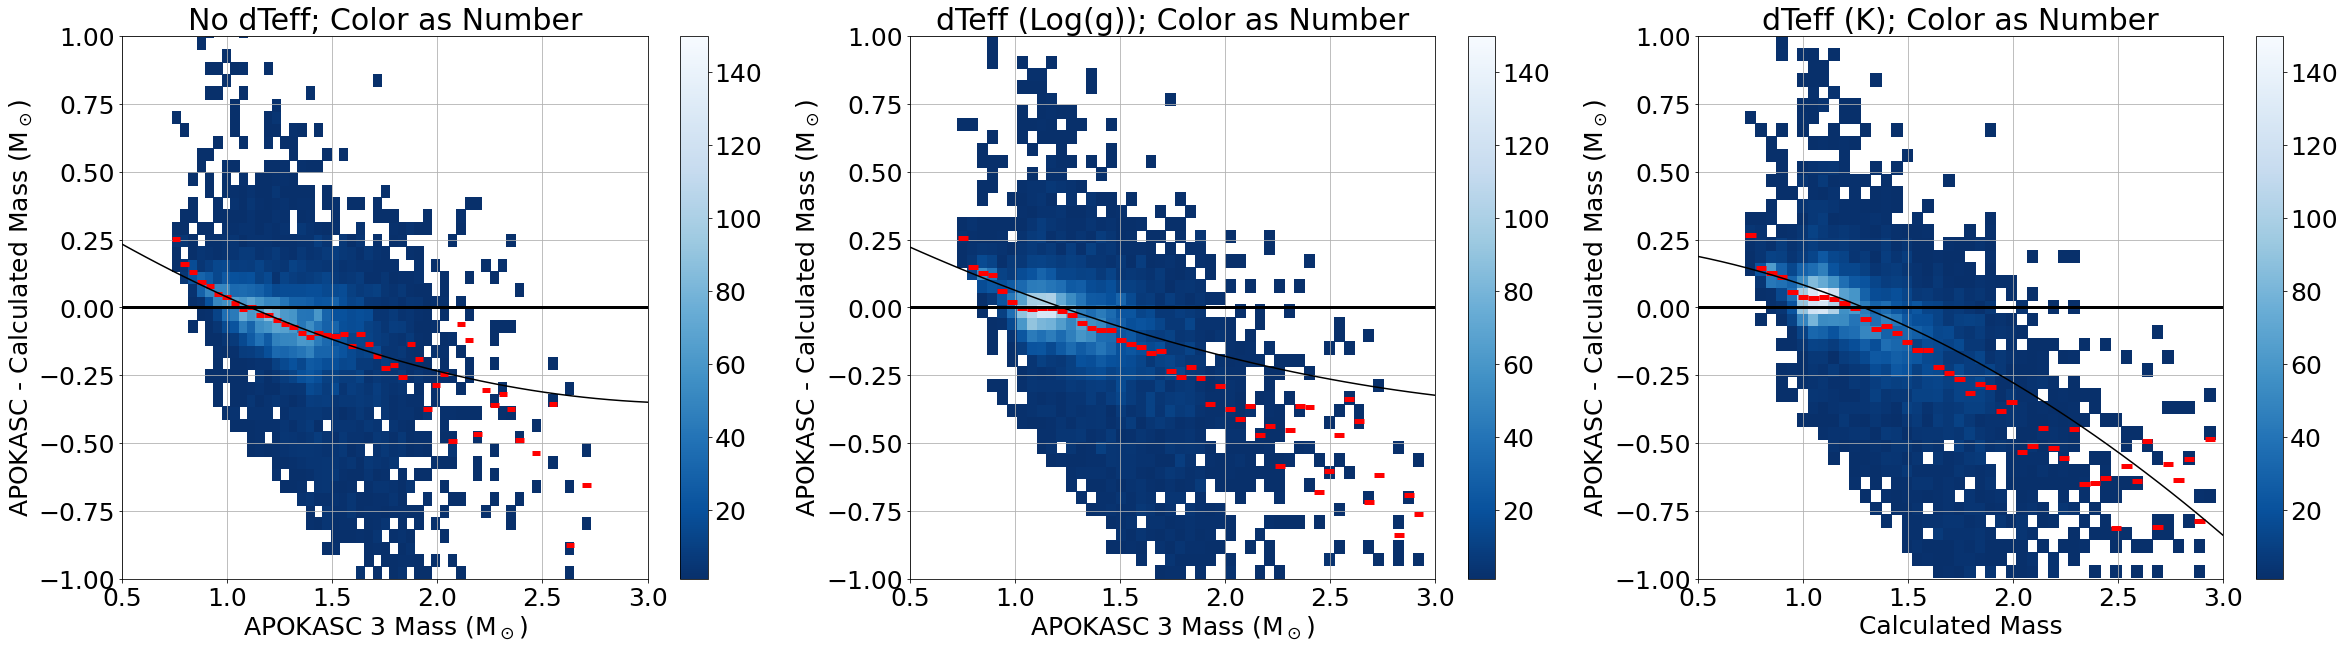

In [284]:
plt.figure(figsize=[40,10])

###
plt.subplot(131)
finfeh = np.where((np.isfinite(kdr17['FE_H'][badcut])==True)&(xmass<=4.0)&(xmass-ymass>=-1))
plt.hist2d(ymass[finfeh],(xmass-ymass)[finfeh],bins=50,cmap='Blues_r',cmin=1,vmax=150)

meds,edgs,_=binned_statistic(ymass[finfeh],(xmass-ymass)[finfeh],statistic='median',bins=50)
pmass = np.poly1d(robust.polyfit(ymass[finfeh],(xmass-ymass)[finfeh],2))
plt.plot(np.linspace(0,3),pmass(np.linspace(0,3)),c='k')
plt.hlines(meds,edgs[:-1],edgs[1:],colors='r',lw=5.)

plt.axhline(0.,c='k',lw=3.0)

plt.xlim(0.5,3)
plt.ylim(-1.,1.)
plt.grid()

plt.title(r'No dTeff; Color as Number')
plt.xlabel('APOKASC 3 Mass (M$_\odot$)')
plt.ylabel('APOKASC - Calculated Mass (M$_\odot$)')
plt.colorbar()

###
plt.subplot(132)
finfeh_logg = np.where((np.isfinite(kdr17['FE_H'][badcut_logg])==True)&
                       (xmass_logg<4.0)&(xmass_logg-ymass_logg>=-1))
plt.hist2d(ymass_logg[finfeh_logg],(xmass_logg-ymass_logg)[finfeh_logg],bins=50,cmap='Blues_r',cmin=1,vmax=150)

meds_logg,edgs_logg,_=binned_statistic(ymass_logg[finfeh_logg],(xmass_logg-ymass_logg)[finfeh_logg],
                                       statistic='median',bins=50)
pmass_logg = np.poly1d(robust.polyfit(ymass_logg[finfeh_logg][:20],(xmass_logg-ymass_logg)[finfeh_logg][:20],2))
plt.plot(np.linspace(0,3),pmass_logg(np.linspace(0,3)),c='k')
plt.hlines(meds_logg,edgs_logg[:-1],edgs_logg[1:],colors='r',lw=5.)

plt.axhline(0.,c='k',lw=3.0)

plt.xlim(0.5,3)
plt.ylim(-1.,1.)
plt.grid()

plt.title(r'dTeff (Log(g)); Color as Number')
plt.xlabel('APOKASC 3 Mass (M$_\odot$)')
plt.ylabel('APOKASC - Calculated Mass (M$_\odot$)')
plt.colorbar()

###
plt.subplot(133)
finfeh_k = np.where((np.isfinite(kdr17['FE_H'][badcut_k])==True)&(xmass>-1)&(xmass_k<4.0)&(xmass_k-ymass_k>=-1))
plt.hist2d(ymass_k[finfeh_k],(xmass_k-ymass_k)[finfeh_k],bins=50,cmap='Blues_r',cmin=1,vmax=150)

meds_k,edgs_k,_=binned_statistic(ymass_k[finfeh_k],(xmass_k-ymass_k)[finfeh_k],statistic='median',bins=50)
pmass_k = np.poly1d(robust.polyfit(ymass_k[finfeh_k][:20],(xmass_k-ymass_k)[finfeh_k][:20],2))
plt.plot(np.linspace(0,3),pmass_k(np.linspace(0,3)),c='k')
plt.hlines(meds_k,edgs_k[:-1],edgs_k[1:],colors='r',lw=5.)

plt.axhline(0.,c='k',lw=3.0)

plt.xlim(0.5,3)
plt.ylim(-1.,1.)
plt.grid()

plt.title(r'dTeff (K); Color as Number')
plt.xlabel('Calculated Mass')
plt.ylabel('APOKASC - Calculated Mass (M$_\odot$)')
plt.colorbar()

plt.show()

No dTeff:           2
0.07853 x - 0.5072 x + 0.4664
dTeff (logg):           2
0.04989 x - 0.3925 x + 0.4057
dTeff (K):           2
-0.1007 x - 0.05805 x + 0.2422


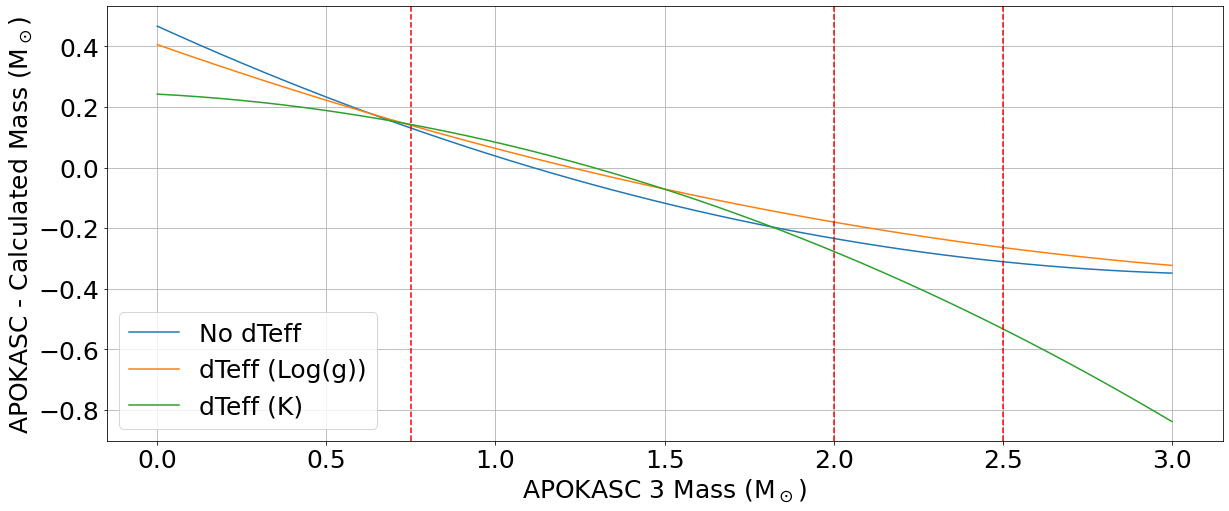

In [263]:
print('No dTeff: ',pmass)
print('dTeff (logg): ',pmass_logg)
print('dTeff (K): ',pmass_k)

plt.figure(figsize=[20,8])
plt.plot(np.linspace(0,3),pmass(np.linspace(0,3)),label='No dTeff')
plt.plot(np.linspace(0,3),pmass_logg(np.linspace(0,3)),label='dTeff (Log(g))')
plt.plot(np.linspace(0,3),pmass_k(np.linspace(0,3)),label='dTeff (K)')

plt.axvline(0.75,ls='--',c='r')
plt.axvline(2.0,ls='--',c='r')
plt.axvline(2.5,ls='--',c='r')

plt.grid()

plt.legend()

plt.xlabel(r'''APOKASC 3 Mass (M$_\odot$)''')
plt.ylabel(r'''APOKASC - Calculated Mass (M$_\odot$)''')
plt.show()

In [264]:
# import corner
# ndim, nsamples = 3, 50000

# data1 = np.random.randn(ndim * 4 * nsamples // 5).reshape([4 * nsamples // 5, ndim])
# data2 = (4*np.random.rand(ndim)[None, :] + np.random.randn(ndim * nsamples // 5).reshape([nsamples // 5, ndim]))
# data = np.vstack([data1, data2])

# # Plot it.
# figure = corner.corner(data, labels=[r"$x$", r"$y$", r"$\log \alpha$", r"$\Gamma \, [\mathrm{parsec}]$"],
#                        quantiles=[0.16, 0.5, 0.84],
#                        show_titles=True, title_kwargs={"fontsize": 12})


# Look At Mass Residual Iterative Correction

Text(0, 0.5, 'APOKASC - Calculated Mass (M$_\\odot$)')

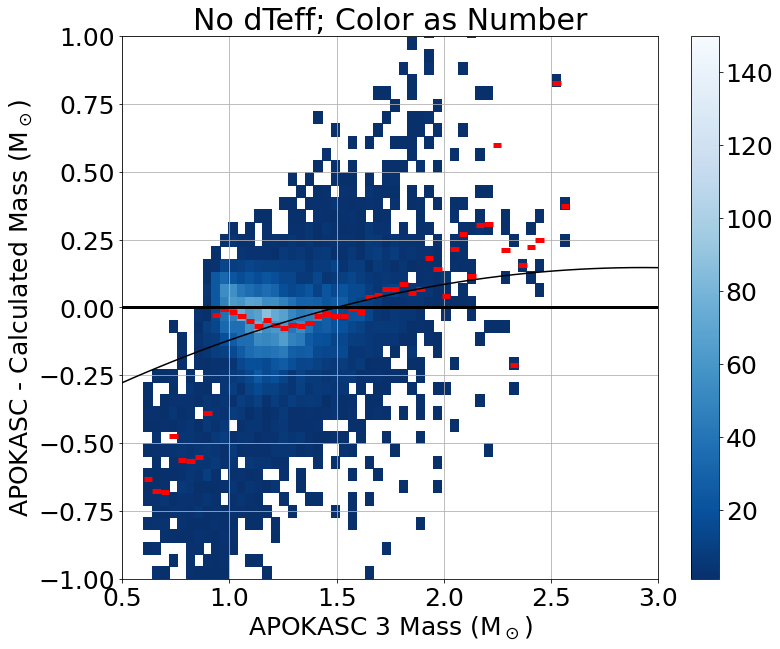

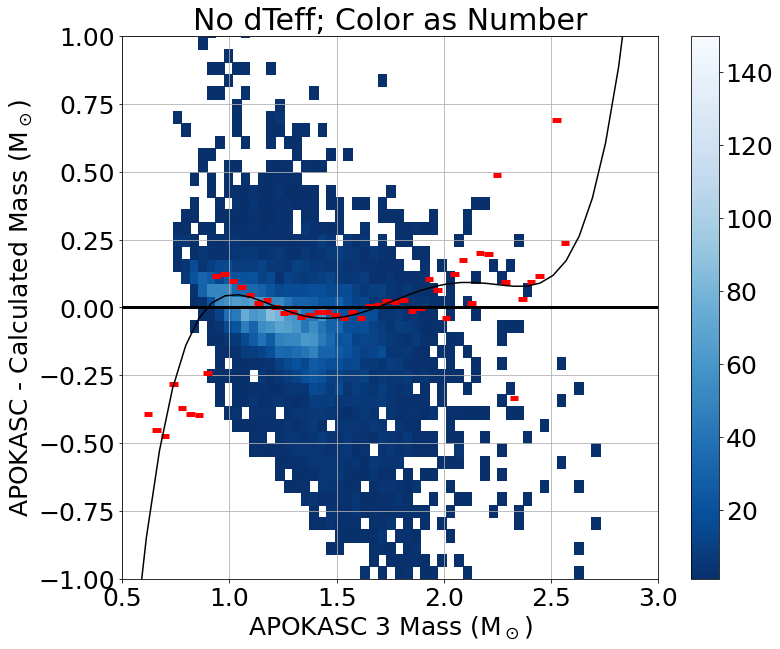

In [319]:
plt.figure(figsize=[12,10])
finfeh = np.where((np.isfinite(kdr17['FE_H'][badcut])==True)&(xmass<=4.0)&(xmass-ymass>=-1))
plt.hist2d(xmass[finfeh],(xmass-ymass)[finfeh],bins=50,cmap='Blues_r',cmin=1,vmax=150)

meds,edgs,_=binned_statistic(xmass[finfeh],(xmass-ymass)[finfeh],statistic='median',bins=50)
pmass = np.poly1d(robust.polyfit(xmass[finfeh],(xmass-ymass)[finfeh],2))
plt.plot(np.linspace(0,3),pmass(np.linspace(0,3)),c='k')
plt.hlines(meds,edgs[:-1],edgs[1:],colors='r',lw=5.)

plt.colorbar()

plt.axhline(0.,c='k',lw=3.0)

plt.xlim(0.5,3)
plt.ylim(-1.,1.)
plt.grid()

plt.title(r'No dTeff; Color as Number')
plt.xlabel('APOKASC 3 Mass (M$_\odot$)')
plt.ylabel('APOKASC - Calculated Mass (M$_\odot$)')

###
plt.figure(figsize=[12,10])
plt.hist2d(ymass[finfeh],(xmass-ymass)[finfeh],bins=50,cmap='Blues_r',cmin=1,vmax=150)

meds2,edgs2,_=binned_statistic(xmass[finfeh],(xmass-ymass)[finfeh]-pmass(xmass[finfeh]),
                               statistic='median',bins=50)
pmass2 = np.poly1d(robust.polyfit(xmass[finfeh],(xmass-ymass)[finfeh]-pmass(xmass[finfeh]),5))
plt.plot(np.linspace(0,3),pmass2(np.linspace(0,3)),c='k')
plt.hlines(meds2,edgs2[:-1],edgs2[1:],colors='r',lw=5.)

plt.colorbar()

plt.axhline(0.,c='k',lw=3.0)

plt.xlim(0.5,3)
plt.ylim(-1.,1.)
plt.grid()

plt.title(r'No dTeff; Color as Number')
plt.xlabel('APOKASC 3 Mass (M$_\odot$)')
plt.ylabel('APOKASC - Calculated Mass (M$_\odot$)')

In [309]:
pmass2

poly1d([ 0.00098343, -0.00119353])

In [301]:
print('Bins Median',np.nanmedian(meds))
print('Resids Median',np.nanmedian((xmass-ymass)[finfeh]))
print('Resids Median after quad',np.nanmedian(meds2))

Bins Median -0.1139235179246042
Resids Median -0.045747384616427134
Resids Median after quad -0.007013272640260859


In [282]:
plt.figure(figsize=[12,10])
finfeh = np.where((np.isfinite(kdr17['FE_H'][badcut])==True)&(xmass<=4.0)&(xmass-ymass>=-1))
plt.hist2d(ymass[finfeh],(xmass-ymass)[finfeh],bins=50,cmap='Blues_r',cmin=1,vmax=150)

meds,edgs,_=binned_statistic(ymass[finfeh],(xmass-ymass)[finfeh],statistic='median',bins=50)
pmass = np.poly1d(robust.polyfit(ymass[finfeh],(xmass-ymass)[finfeh],2))
# plt.plot(np.linspace(0,3),pmass(np.linspace(0,3)),c='k')
# plt.hlines(meds,edgs[:-1],edgs[1:],colors='r',lw=5.)

plt.hist2d(ymass[finfeh],(xmass-ymass)[finfeh],bins=50,cmap='Blues_r',cmin=1,vmax=150)

plt.axhline(0.,c='k',lw=3.0)

plt.xlim(0.5,3)
plt.ylim(-1.,1.)
plt.grid()

plt.title(r'Color as Number')
plt.xlabel('APOKASC 3 Mass (M$_\odot$)')
plt.ylabel('APOKASC - Calculated Mass (M$_\odot$)')
plt.colorbar()

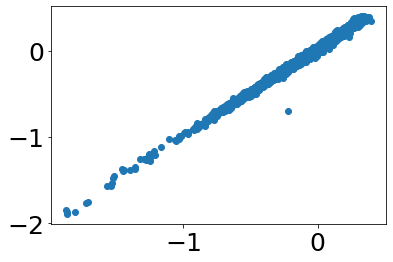

In [265]:
plt.scatter(kdr17['FE_H'],k3dr17['Fe/H'])

In [266]:
dr16 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-r12-l33.fits.gz')
_,test_16,test_3 = np.intersect1d(dr16['APOGEE_ID'],k3dr17['2MASSID'],return_indices=True)

k3dr16 = k3dr17[test_3] 
kdr16 = dr16[test_16]

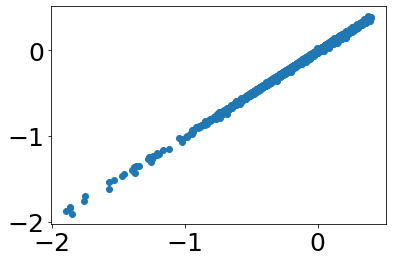

In [267]:
plt.scatter(k3dr16['Fe/H'],kdr16['FE_H'])

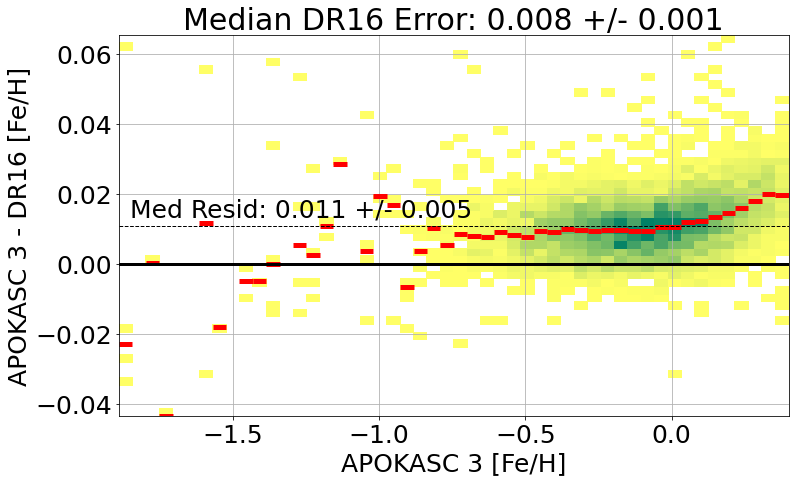

In [268]:
plt.figure(figsize=[12,7])
# plt.scatter(k3dr16['Fe/H'],k3dr16['Fe/H']-kdr16['FE_H'])
plt.hist2d(k3dr16['Fe/H'],k3dr16['Fe/H']-kdr16['FE_H'],bins=50,cmap='summer_r',cmin=1)

meds_feh,edgs_feh,_=binned_statistic(k3dr16['Fe/H'],k3dr16['Fe/H']-kdr16['FE_H'],statistic='median',bins=50)
plt.hlines(meds_feh,edgs_feh[:-1],edgs_feh[1:],colors='r',lw=5.)
plt.axhline(0.0,c='k',lw=3.)
plt.axhline(np.nanmedian(k3dr16['Fe/H']-kdr16['FE_H']),c='k',ls='--',lw=1.)
plt.text(-1.85,0.0135,r'Med Resid: {:.3f} +/- {:.3f}'.format(np.nanmedian(k3dr16['Fe/H']-kdr16['FE_H']),
                                                             mad(k3dr16['Fe/H']-kdr16['FE_H'])))
plt.grid()

plt.title(r'Median DR16 Error: {:.3f} +/- {:.3f}'.format(np.nanmedian(kdr16['FE_H_ERR']),mad(kdr16['FE_H_ERR'])))
plt.xlabel('APOKASC 3 [Fe/H]')
plt.ylabel('APOKASC 3 - DR16 [Fe/H]')

plt.savefig('../plots/apokasc3_dr16_FEH.pdf',bbox_inches='tight',dpi=300)
plt.show()

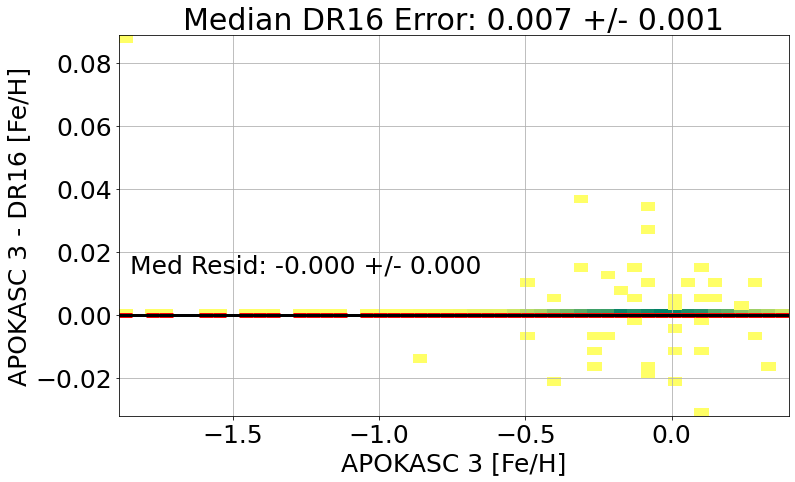

In [275]:
plt.figure(figsize=[12,7])
# plt.scatter(k3dr16['Fe/H'],k3dr16['Fe/H']-kdr16['M_H'])
plt.hist2d(k3dr16['Fe/H'],k3dr16['Fe/H']-kdr16['M_H'],bins=50,cmap='summer_r',cmin=1)

meds_feh,edgs_feh,_=binned_statistic(k3dr16['Fe/H'],k3dr16['Fe/H']-kdr16['M_H'],statistic='median',bins=50)
plt.hlines(meds_feh,edgs_feh[:-1],edgs_feh[1:],colors='r',lw=5.)
plt.axhline(0.0,c='k',lw=3.)
plt.axhline(np.nanmedian(k3dr16['Fe/H']-kdr16['M_H']),c='k',ls='--',lw=1.)
plt.text(-1.85,0.0135,r'Med Resid: {:.3f} +/- {:.3f}'.format(np.nanmedian(k3dr16['Fe/H']-kdr16['M_H']),
                                                             mad(k3dr16['Fe/H']-kdr16['M_H'])))
plt.grid()

plt.title(r'Median DR16 Error: {:.3f} +/- {:.3f}'.format(np.nanmedian(kdr16['M_H_ERR']),mad(kdr16['M_H_ERR'])))
plt.xlabel('APOKASC 3 [Fe/H]')
plt.ylabel('APOKASC 3 - DR16 [Fe/H]')

# plt.savefig('../plots/apokasc3_dr16_FEH.pdf',bbox_inches='tight',dpi=300)
plt.show()

In [269]:
print(np.nanmedian(kdr17['FE_H_ERR']))
print(np.nanmedian(kdr16['FE_H_ERR']))

0.008463351
0.008244557


Text(0, 0.5, 'APOKASC 3 - DR16 Log(g)')

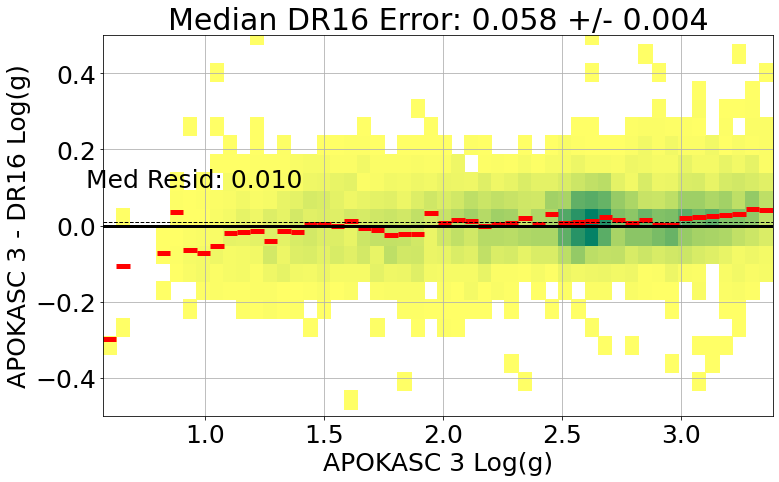

In [270]:
plt.figure(figsize=[12,7])
plt.hist2d(k3dr16['Logg'],k3dr16['Logg']-kdr16['LOGG'],bins=50,cmap='summer_r',cmin=1)

meds_logg,edgs_logg,_=binned_statistic(k3dr16['Logg'],k3dr16['Logg']-kdr16['LOGG'],statistic='median',bins=50)
plt.hlines(meds_logg,edgs_logg[:-1],edgs_logg[1:],colors='r',lw=5.)
plt.axhline(0.0,c='k',lw=3.)
plt.axhline(np.nanmedian(k3dr16['Logg']-kdr16['LOGG']),c='k',ls='--',lw=1.)
plt.text(0.5,0.1,r'Med Resid: {:.3f}'.format(np.nanmedian(k3dr16['Logg']-kdr16['LOGG'])))
plt.ylim(-0.5,0.5)
plt.grid()

plt.title(r'Median DR16 Error: {:.3f} +/- {:.3f}'.format(np.nanmedian(kdr16['LOGG_ERR']),mad(kdr16['LOGG_ERR'])))
plt.xlabel('APOKASC 3 Log(g)')
plt.ylabel('APOKASC 3 - DR16 Log(g)')

Text(0, 0.5, 'APOKASC 3 - DR16 Teff')

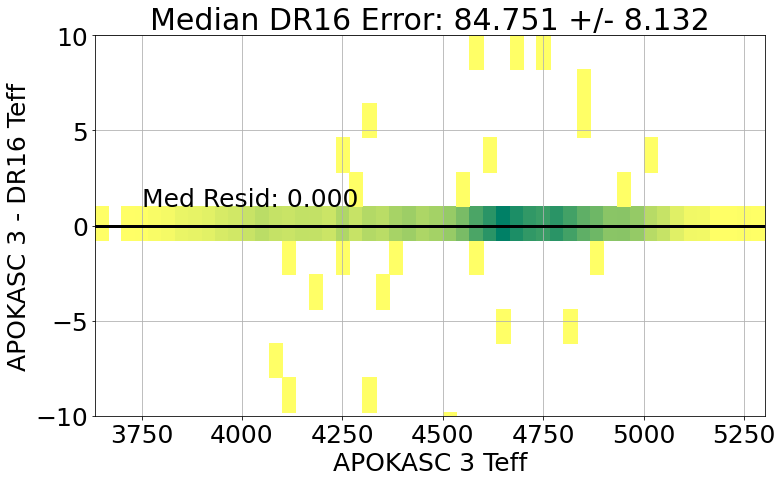

In [271]:
plt.figure(figsize=[12,7])
plt.hist2d(k3dr16['Teff'],k3dr16['Teff']-kdr16['TEFF'],bins=50,cmap='summer_r',cmin=1)

meds_logg,edgs_logg,_=binned_statistic(k3dr16['Teff'],k3dr16['Teff']-kdr16['FE_H'],statistic='median',bins=50)
plt.hlines(meds_logg,edgs_logg[:-1],edgs_logg[1:],colors='r',lw=5.)
plt.axhline(0.0,c='k',lw=3.)
plt.axhline(np.nanmedian(k3dr16['Teff']-kdr16['TEFF']),c='k',ls='--',lw=1.)
plt.text(3750,1.,r'Med Resid: {:.3f}'.format(np.nanmedian(k3dr16['Teff']-kdr16['TEFF'])))
plt.ylim(-10,10)
plt.grid()

plt.title(r'Median DR16 Error: {:.3f} +/- {:.3f}'.format(np.nanmedian(kdr16['TEFF_ERR']),
                                                         mad(kdr16['TEFF_ERR'])))
plt.xlabel('APOKASC 3 Teff')
plt.ylabel('APOKASC 3 - DR16 Teff')

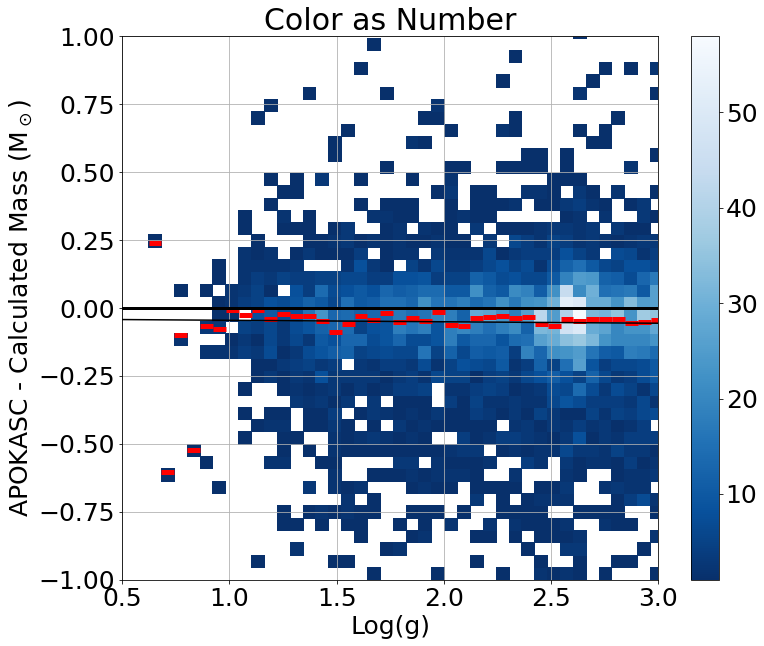

 
-0.005411 x - 0.03981


In [272]:
loggfin = np.where(np.isfinite(kdr17['LOGG'][finfeh])==True)

plt.figure(figsize=[12,10])

###
finfeh = np.where((np.isfinite(kdr17['FE_H'][badcut])==True)&(xmass<=4.0)&(xmass-ymass>=-1))
plt.hist2d(kdr17['LOGG'][finfeh][loggfin],(xmass-ymass)[finfeh][loggfin],bins=50,cmap='Blues_r',cmin=1)

meds,edgs,_=binned_statistic(kdr17['LOGG'][finfeh][loggfin],(xmass-ymass)[finfeh][loggfin],statistic='median',bins=50)
plogg = np.poly1d(robust.polyfit(kdr17['LOGG'][finfeh][loggfin],(xmass-ymass)[finfeh][loggfin],1))
plt.plot(np.linspace(0,3),plogg(np.linspace(0,3)),c='k')
plt.hlines(meds,edgs[:-1],edgs[1:],colors='r',lw=5.)

plt.axhline(0.,c='k',lw=3.0)

plt.xlim(0.5,3)
plt.ylim(-1.,1.)
plt.grid()

plt.title(r'Color as Number')
plt.xlabel('Log(g)')
plt.ylabel('APOKASC - Calculated Mass (M$_\odot$)')
plt.colorbar()

plt.savefig('../plots/massresid_logg.pdf',dpi=300,bbox_inches='tight')
plt.show()

print(plogg)